In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro_glm.count.models as glm_count
import pandas as pd

numpyro.set_host_device_count(4)

# Chapter 24: Count Predicted Variable
## Poisson Exponential Model
### Example: Hair Eye Go Again

In [3]:
hair_eye_df: pd.DataFrame = pd.read_csv(
    'datasets/HairEyeColor.csv',
    dtype=dict(Hair='category', Eye='category'))
hair_eye_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Hair    16 non-null     category
 1   Eye     16 non-null     category
 2   Count   16 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 352.0 bytes


In [4]:
kernel = NUTS(glm_count.two_nominal_predictors)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(hair_eye_df['Count'].values),
    x1=jnp.array(hair_eye_df['Eye'].cat.codes.values),
    x2=jnp.array(hair_eye_df['Hair'].cat.codes.values),
    K1=hair_eye_df['Eye'].cat.categories.size,
    K2=hair_eye_df['Hair'].cat.categories.size,
)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       _a0      3.19      1.30      3.20      1.29      5.10  12363.95      1.00
    _a1[0]      0.37      0.93      0.30     -0.84      1.70  12684.24      1.00
    _a1[1]      0.28      0.92      0.22     -0.94      1.60  12847.48      1.00
    _a1[2]     -0.42      0.93     -0.35     -1.77      0.79  13091.56      1.00
    _a1[3]     -0.21      0.92     -0.17     -1.51      1.04  13051.19      1.00
    _a1_sd      1.25      1.37      0.85      0.02      2.54  15191.71      1.00
_a1a2[0,0]     -0.34      0.57     -0.34     -1.26      0.59  52378.37      1.00
_a1a2[0,1]      1.17      0.55      1.16      0.28      2.08  52236.69      1.00
_a1a2[0,2]      0.15      0.60      0.14     -0.80      1.14  38956.74      1.00
_a1a2[0,3]     -0.43      0.57     -0.42     -1.36      0.50  51948.70      1.00
_a1a2[1,0]      0.94      0.55      0.93      0.03      1.83  55624.82      1.00
_a1a2[1,1]     -1.15      0

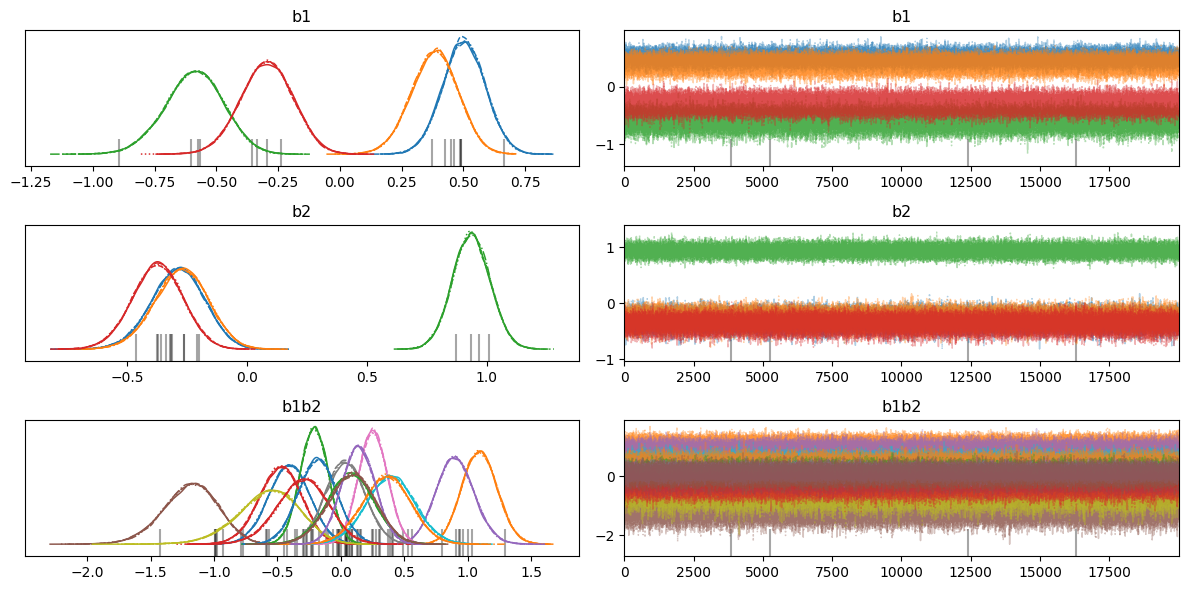

In [5]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(
        Hair=hair_eye_df['Hair'].cat.categories,
        Eye=hair_eye_df['Eye'].cat.categories),
    dims=dict(
        b1=['Eye'], b2=['Hair'],
        b1b2=['Eye', 'Hair'],
        P=['Eye', 'Hair'],
        P_x1=['Eye'], P_x2=['Hair'])
)
az.plot_trace(idata, ['b1', 'b2', 'b1b2'])
plt.tight_layout()

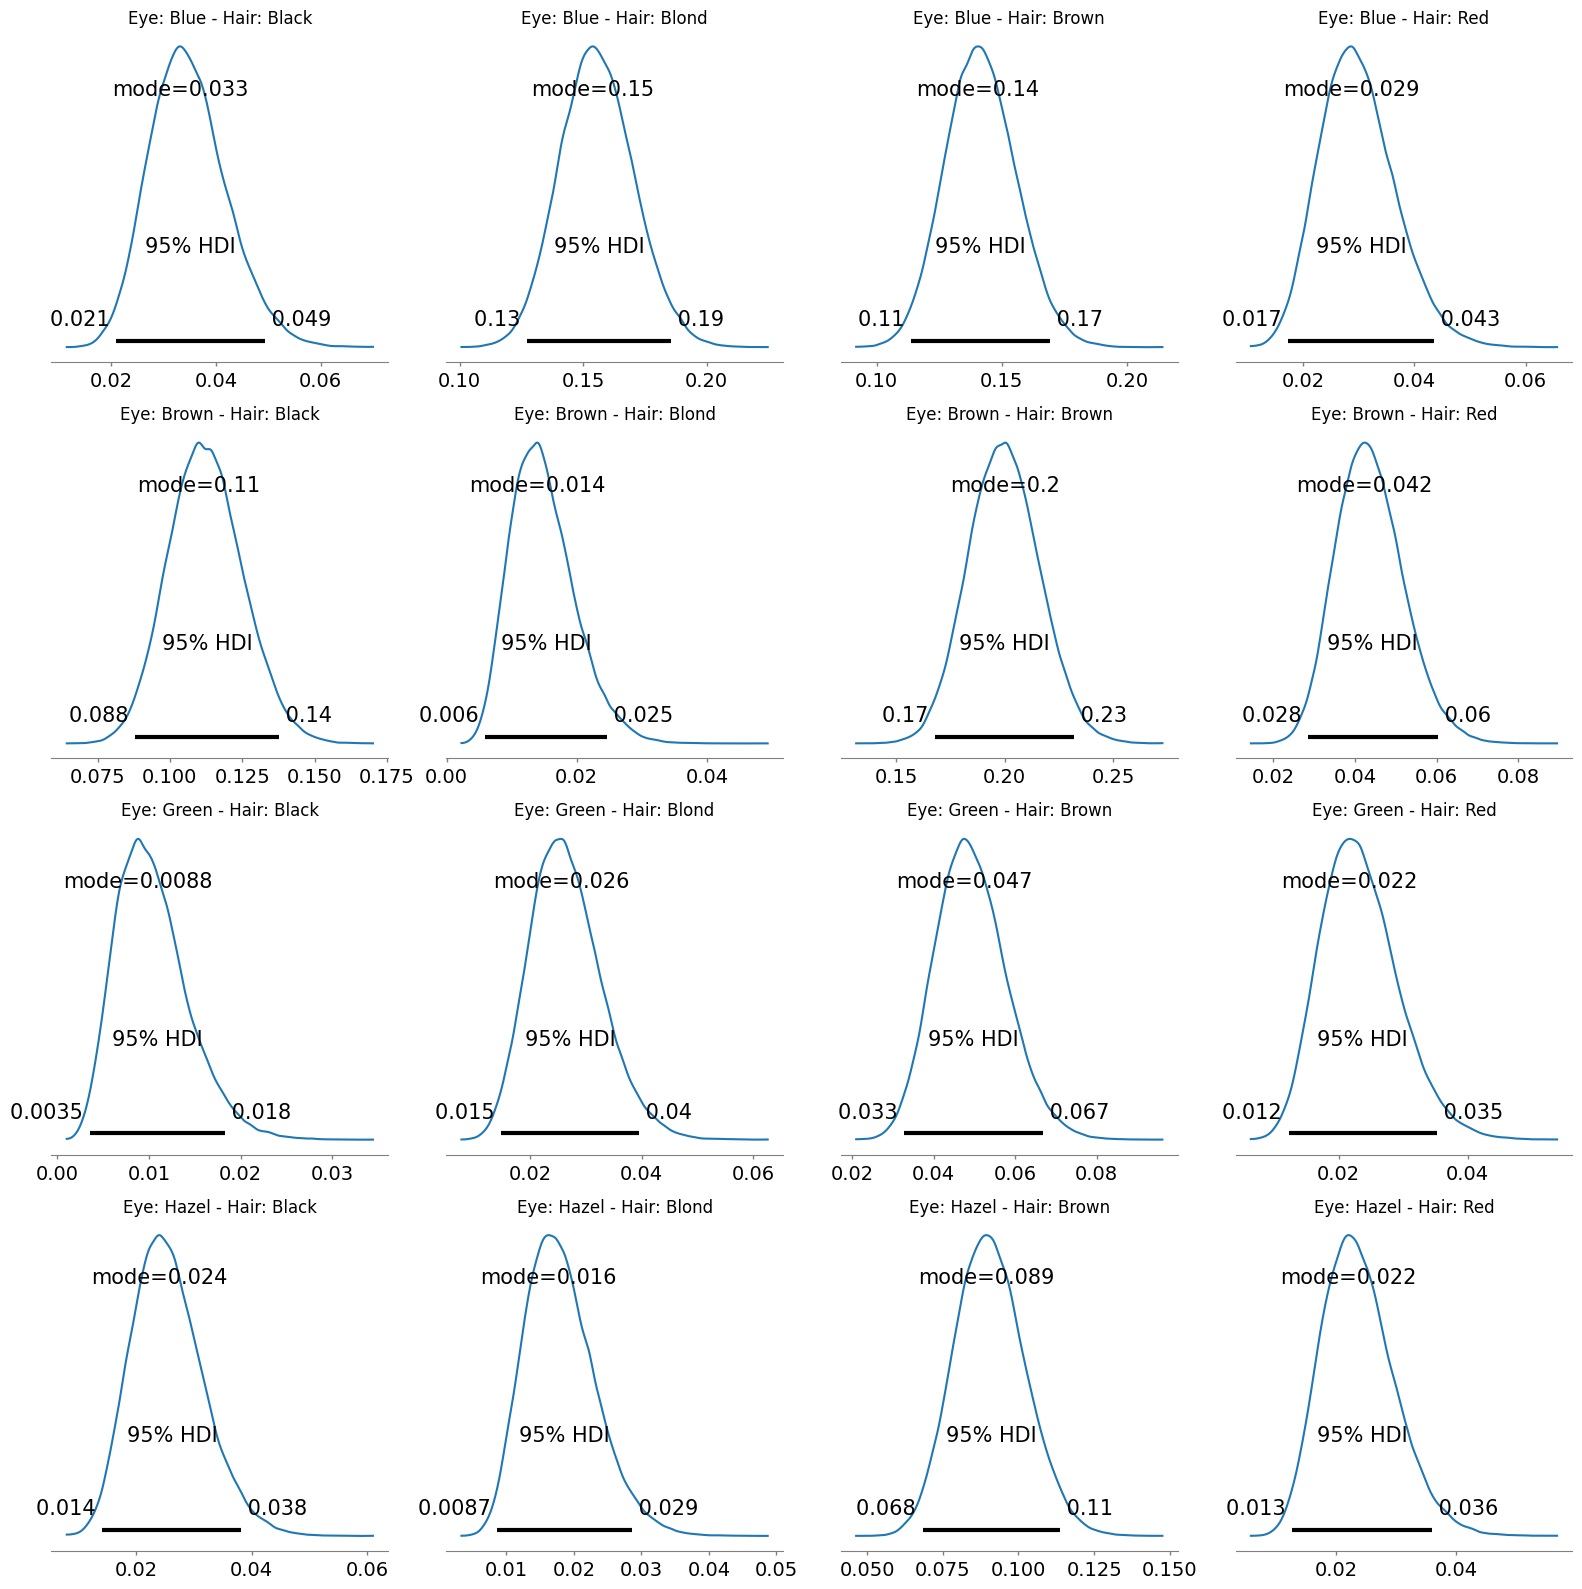

In [6]:
fig, axes = plt.subplots(
    nrows=hair_eye_df['Eye'].cat.categories.size,
    ncols=hair_eye_df['Hair'].cat.categories.size,
    figsize=(16, 16))

posterior = idata['posterior']
for i, eye in enumerate(hair_eye_df['Eye'].cat.categories):
    for j, hair in enumerate(hair_eye_df['Hair'].cat.categories):
        ax = axes[i, j]
        p = posterior['P'].sel(Eye=eye, Hair=hair).values
        az.plot_posterior(p, hdi_prob=.95, point_estimate='mode', ax=ax)
        ax.set_title(f'Eye: {eye} - Hair: {hair}')

fig.tight_layout()

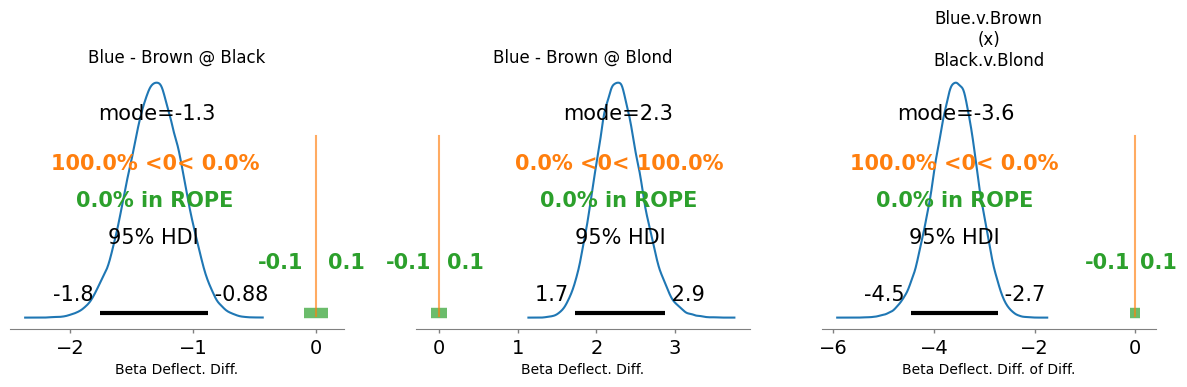

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

blue_eye_black_hair = posterior['b1b2'].sel(Eye='Blue', Hair='Black').values
brown_eye_black_hair = posterior['b1b2'].sel(Eye='Brown', Hair='Black').values

blue_eye_blond_hair = posterior['b1b2'].sel(Eye='Blue', Hair='Blond').values
brown_eye_blond_hair = posterior['b1b2'].sel(Eye='Brown', Hair='Blond').values

diff_black = blue_eye_black_hair - brown_eye_black_hair
diff_blond = blue_eye_blond_hair - brown_eye_blond_hair
diff = diff_black - diff_blond

ax = axes[0]
az.plot_posterior(
    diff_black, hdi_prob=.95, point_estimate='mode', ref_val=0, rope=(-0.1, 0.1), ax=ax)
ax.set_title('Blue - Brown @ Black')
ax.set_xlabel('Beta Deflect. Diff.')

ax = axes[1]
az.plot_posterior(
    diff_blond, hdi_prob=.95, point_estimate='mode', ref_val=0, rope=(-0.1, 0.1), ax=ax)
ax.set_title('Blue - Brown @ Blond')
ax.set_xlabel('Beta Deflect. Diff.')

ax = axes[2]
az.plot_posterior(
    diff, hdi_prob=.95, point_estimate='mode', ref_val=0, rope=(-0.1, 0.1), ax=ax)
ax.set_title('Blue.v.Brown\n(x)\nBlack.v.Blond')
ax.set_xlabel('Beta Deflect. Diff. of Diff.')

fig.tight_layout()